In [1]:
# Load captured npz
import numpy as np
captured_obs = list(np.load("real_images/mug_obs_1.npz", allow_pickle=True).values())[0].tolist()
images = [captured_obs["image"]["front_camera"]["rgb"]]
captured_obs = list(np.load("real_images/mug_obs_3.npz", allow_pickle=True).values())[0].tolist()
images += [captured_obs["image"]["front_camera"]["rgb"]]
captured_obs.keys()

dict_keys(['camera_param', 'image'])

In [2]:
# OWL_ViT
from collections import defaultdict
import torch
import numpy as np
import open3d as o3d
text_queries = ["mug", "mug handle"]  # ["red cube", "green bowl"]
#images = [captured_obs["image"]["front_camera"]["rgb"]]
device = "cuda"

from transformers import OwlViTProcessor, OwlViTForObjectDetection
if 'model' not in dir():
    model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14")
    processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")

def run_owlvit(model, images, text_queries, device="cuda"):
    """Run OWL-ViT to generate bounding boxes"""
    # Process image and text inputs
    inputs = processor(text=text_queries, images=images, return_tensors="pt").to(device)

    # Print input names and shapes
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")

    # Set model in evaluation mode
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    for k, val in outputs.items():
        if k not in {"text_model_output", "vision_model_output"}:
            print(f"{k}: shape of {val.shape}")

    print("\nText model outputs")
    for k, val in outputs.text_model_output.items():
        print(f"{k}: shape of {val.shape}")

    print("\nVision model outputs")
    for k, val in outputs.vision_model_output.items():
        print(f"{k}: shape of {val.shape}")

    from transformers.image_transforms import center_to_corners_format
    from transformers.models.owlvit.image_processing_owlvit import box_iou

    def post_process_object_detection(outputs, threshold=0.1, nms_threshold=0.3, target_sizes=None):
        logits, boxes = outputs.logits, outputs.pred_boxes

        if target_sizes is not None:
            if len(logits) != len(target_sizes):
                raise ValueError("Make sure that you pass in as many target sizes as the batch dimension of the logits")
            if target_sizes.shape[1] != 2:
                raise ValueError("Each element of target_sizes must contain the size (h, w) of each image of the batch")

        probs = torch.max(logits, dim=-1)
        scores = torch.sigmoid(probs.values)
        labels = probs.indices

        # Convert to [x0, y0, x1, y1] format
        boxes = center_to_corners_format(boxes)

        # Apply non-maximum suppression (NMS)
        if nms_threshold < 1.0:
            for idx in range(boxes.shape[0]):  # batch
                for i in torch.argsort(-scores[idx]):
                    if not scores[idx][i]:
                        continue

                    ious = box_iou(boxes[idx][i, :].unsqueeze(0), boxes[idx])[0][0]
                    ious[i] = -1.0  # Mask self-IoU.
                    scores[idx][ious > nms_threshold] = 0.0

        # Convert from relative [0, 1] to absolute [0, height] coordinates
        if target_sizes is not None:
            img_h, img_w = target_sizes.unbind(1)
            scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
            boxes = boxes * scale_fct[:, None, :]
        
        results = []
        for s, l, b in zip(scores, labels, boxes):
            score = s[s > threshold]
            label = l[s > threshold]
            box = b[s > threshold]
            results.append({"scores": score, "labels": label, "boxes": box})
        return results

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.shape[:2] for image in images]).to(device)

    # Convert outputs (bounding boxes and class logits) to COCO API
    results = post_process_object_detection(outputs=outputs, threshold=0.1, nms_threshold=1.0,  # NOTE: no NMS
                                            target_sizes=target_sizes)

    for k, val in results[0].items():
        print(f"{k}: shape of {val.shape}")
    
    return results

2023-08-05 21:10:29.310329: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-05 21:10:29.324937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# SAM
from time import time
from segment_anything import build_sam, sam_model_registry, SamPredictor
device = "cuda"

start_time = time()
sam_model = sam_model_registry["vit_h"](checkpoint="/rl_benchmark/grounded-sam/models/sam_vit_h_4b8939.pth").to(device)
sam_predictor = SamPredictor(sam_model)
print(f"\nLoading SAM: Took {time() - start_time:.3f} seconds")

sam_predictor


Loading SAM: Took 3.484 seconds


In [4]:
results = run_owlvit(model, images, [text_queries]*len(images), device)
results

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([2, 3, 840, 840])
logits: shape of torch.Size([2, 3600, 2])
pred_boxes: shape of torch.Size([2, 3600, 4])
text_embeds: shape of torch.Size([2, 2, 768])
image_embeds: shape of torch.Size([2, 60, 60, 1024])
class_embeds: shape of torch.Size([2, 3600, 768])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 768])
pooler_output: shape of torch.Size([4, 768])

Vision model outputs
last_hidden_state: shape of torch.Size([2, 3601, 1024])
pooler_output: shape of torch.Size([2, 1024])
scores: shape of torch.Size([12])
labels: shape of torch.Size([12])
boxes: shape of torch.Size([12, 4])


[{'scores': tensor([0.1011, 0.2934, 0.5156, 0.1922, 0.1465, 0.1252, 0.4382, 0.1668, 0.1346,
          0.1813, 0.1815, 0.1153], device='cuda:0'),
  'labels': tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0'),
  'boxes': tensor([[201.2083,   8.9127, 507.1778, 416.1563],
          [503.9182, 238.8909, 677.2323, 426.1031],
          [345.3991, 309.2613, 436.5867, 393.9211],
          [348.9749, 324.9315, 377.4313, 372.5046],
          [348.1953, 308.3794, 437.7090, 395.6328],
          [346.0204, 307.5961, 441.1448, 394.3283],
          [201.6842, 327.2183, 294.6620, 425.1974],
          [198.8249, 325.8603, 293.5395, 425.9786],
          [196.2502, 322.0161, 295.6251, 424.0934],
          [263.3815, 353.6541, 294.9331, 410.1220],
          [ -1.2215, 443.2664, 104.0115, 480.2308],
          [104.4712, 437.2344, 142.8008, 478.8085]], device='cuda:0')},
 {'scores': tensor([0.1034, 0.4577, 0.1621, 0.1399, 0.2893, 0.1127, 0.4867, 0.2759, 0.1608,
          0.2381, 0.1565, 0.1705], 

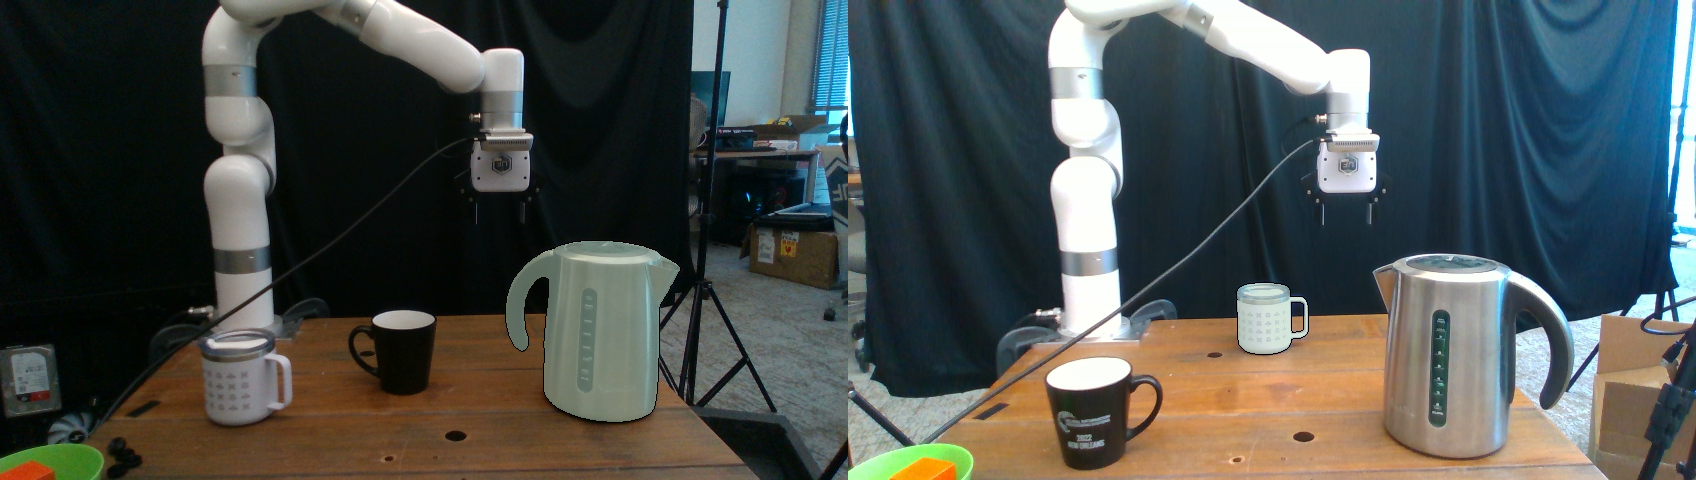

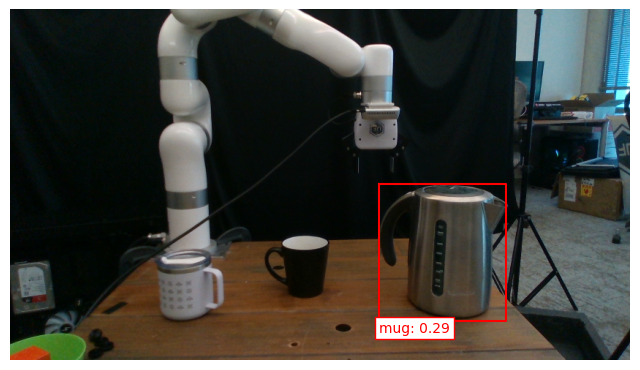

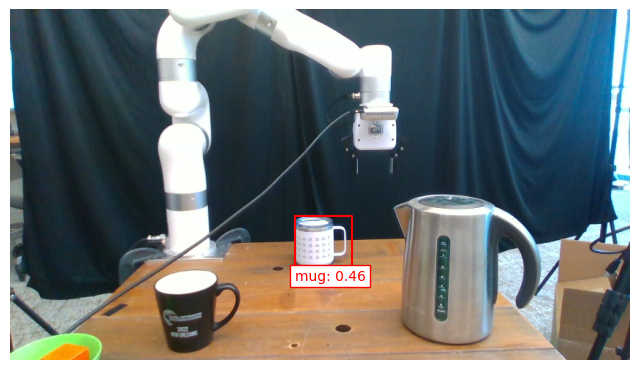

In [5]:
# Visualize predicted bboxes
import matplotlib.pyplot as plt

def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image)
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      x_min, y_min, x_max, y_max = box
      ax.plot([x_min, x_max, x_max, x_min, x_min],
              [y_min, y_min, y_max, y_max, y_min], "r")
      ax.text(
          x_min,
          y_max + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

for i, image in enumerate(images):
    input_image = np.asarray(image).astype(np.float32) / 255.0
    scores, boxes, labels = results[i]["scores"].cpu().numpy(), results[i]["boxes"].cpu().numpy(), results[i]["labels"].cpu().numpy()
    idx = 1
    scores, boxes, labels = scores[[idx]], boxes[[idx]], labels[[idx]]
    plot_predictions(input_image, text_queries, scores, boxes, labels)

# Visualize predicted maskes
from seg_and_track_anything.seg_track_anything import draw_mask, colorize_mask
from PIL import Image

sam_features_batch, pred_masks_batch, iou_preds_batch, low_res_logits_batch = [], [], [], []
for i, image in enumerate(images):
    sam_predictor.set_image(image)
    boxes_transformed = sam_predictor.transform.apply_boxes_torch(results[i]["boxes"], image.shape[:2])
    pred_masks, iou_preds, low_res_logits = sam_predictor.predict_torch(
        point_coords=None, point_labels=None,
        boxes=boxes_transformed.to(device),
        multimask_output=False
    )
    sam_features_batch.append(sam_predictor.features)
    pred_masks_batch.append(pred_masks)
    iou_preds_batch.append(iou_preds)
    low_res_logits_batch.append(low_res_logits)

Image.fromarray(np.hstack([draw_mask(image.copy(), pred_masks.cpu().numpy()[idx, 0]) for image, pred_masks in zip(images, pred_masks_batch)]))

tensor([1.1620, 1.0034, 1.0034, 0.9767, 1.0964, 0.8886, 0.9111, 0.8537, 0.9111,
        0.9111, 0.9111, 1.1135])


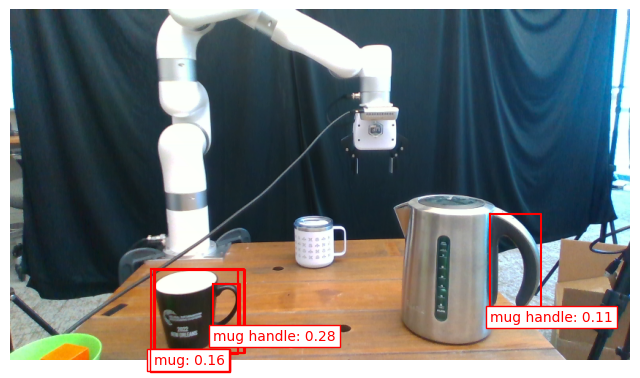

In [6]:
# Plot closest object mask to query_bbox_idx, based on l2 distance of spatially averaged feature vector
from torch.nn import functional as F
feature_masks_batch = [
    F.interpolate(low_res_logits, (64, 64), mode="bilinear", align_corners=False) > sam_predictor.model.mask_threshold
    for low_res_logits in low_res_logits_batch
]  # n_imgs [n_objs, 1, 64, 64]
masked_feature_batch = [
    feature_masks * sam_features
    for feature_masks, sam_features in zip(feature_masks_batch, sam_features_batch)
]  # n_imgs [12, 256, 64, 64]
masked_feature_avg_batch = [
    masked_feature.sum(dim=(-1, -2)) / feature_masks.sum(dim=(-1, -2))
    for masked_feature, feature_masks in zip(masked_feature_batch, feature_masks_batch)
]  # n_imgs [12, 256]

query_bbox_idx = 9
query_img_idx, tgt_img_idx = 0, 1
feature_dists = torch.norm(masked_feature_avg_batch[tgt_img_idx] - masked_feature_avg_batch[query_img_idx][query_bbox_idx], dim=-1).cpu()  # [12]
print(feature_dists)

feature_dists_thres = 0.92

scores, boxes, labels = results[tgt_img_idx]["scores"].cpu().numpy(), results[tgt_img_idx]["boxes"].cpu().numpy(), results[tgt_img_idx]["labels"].cpu().numpy()
scores, boxes, labels = scores[feature_dists < feature_dists_thres], boxes[feature_dists < feature_dists_thres], labels[feature_dists < feature_dists_thres]
plot_predictions(np.asarray(images[tgt_img_idx]).astype(np.float32) / 255.0, text_queries, scores, boxes, labels)

(tensor([341.7358, 437.4167]), torch.Size([1, 480, 848]))

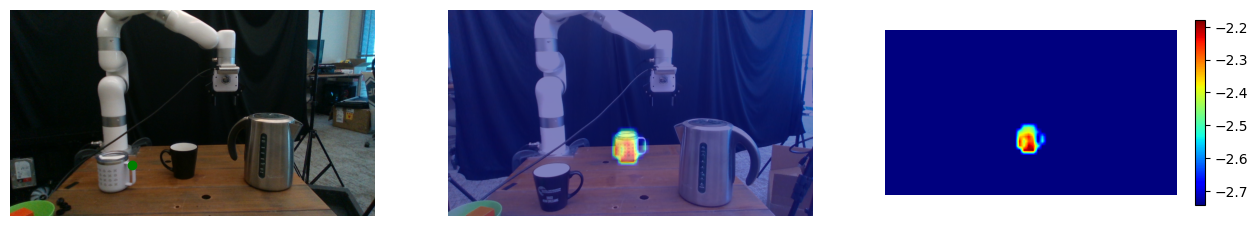

In [21]:
# Plot closest object mask to query_point_coord, based on l2 distance of spatially averaged feature vector
query_point_coord = np.array([283, 362])  # white mug handle top
#query_point_coord = np.array([288, 381])  # white mug handle center
#query_point_coord = np.array([226, 394])  # white mug center
#query_point_coord = np.array([403, 352])  # black mug center
mask_idx = 1  # in tgt_img
query_img_idx, tgt_img_idx = 0, 1
mode = "downsample_feat+mask"

point_transformed = sam_predictor.transform.apply_coords_torch(torch.tensor(query_point_coord), images[query_img_idx].shape[:2])
input_size_to_feature_size = 1024 // 64
feature_coord = (point_transformed // input_size_to_feature_size).to(int)
boxes_transformed = sam_predictor.transform.apply_boxes_torch(results[tgt_img_idx]["boxes"], images[tgt_img_idx].shape[:2])
feature_bbox = (boxes_transformed // input_size_to_feature_size).to(int)
feature_masks = F.interpolate(low_res_logits_batch[tgt_img_idx], (64, 64), mode="bilinear", align_corners=False) > sam_predictor.model.mask_threshold

if mode == "downsample_feat":
    query_feature = sam_features_batch[query_img_idx][..., feature_coord[0], feature_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - sam_features_batch[tgt_img_idx], dim=1)  # [1, 64, 64]
    #feature_dists[~feature_masks[mask_idx]] = feature_dists.max()  # masked
    feature_dists = F.interpolate(feature_dists[None,...], (1024, 1024), mode="bilinear", align_corners=False)  # [1, 1, 1024, 1024]
    feature_dists = feature_dists[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
    feature_dists = F.interpolate(feature_dists, sam_predictor.original_size, mode="bilinear", align_corners=False)[0]  # [1, 480, 848]
elif mode == "upsample_feat":
    # Upsampled image_features
    image_features_batch = [
        F.interpolate(sam_features, (1024, 1024), mode="bilinear", align_corners=False)
        for sam_features in sam_features_batch
    ]  # n_imgs [1, 256, 1024, 1024]
    image_features_batch = [
        image_features[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
        for image_features in image_features_batch
    ]
    image_features_batch = [
        F.interpolate(image_features, sam_predictor.original_size, mode="bilinear", align_corners=False)
        for image_features in image_features_batch
    ]  # n_imgs [1, 256, 480, 848]
    query_feature = image_features_batch[query_img_idx][:, :, query_point_coord[0], query_point_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - image_features_batch[tgt_img_idx], dim=1)  # [1, 480, 848]
    #feature_dists[0, ~pred_masks[mask_idx, 0]] = feature_dists.max()  # masked
elif mode == "downsample_feat+mask":
    query_feature = sam_features_batch[query_img_idx][..., feature_coord[0], feature_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - sam_features_batch[tgt_img_idx], dim=1)  # [1, 64, 64]
    feature_dists[~feature_masks[mask_idx]] = feature_dists.max()  # masked
    feature_dists = F.interpolate(feature_dists[None,...], (1024, 1024), mode="bilinear", align_corners=False)  # [1, 1, 1024, 1024]
    feature_dists = feature_dists[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
    feature_dists = F.interpolate(feature_dists, sam_predictor.original_size, mode="bilinear", align_corners=False)[0]  # [1, 480, 848]
elif mode == "downsample_feat+bbox":
    query_feature = sam_features_batch[query_img_idx][..., feature_coord[0], feature_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - sam_features_batch[tgt_img_idx], dim=1)  # [1, 64, 64]

    x_min, y_min, x_max, y_max = feature_bbox[mask_idx]
    feature_bbox_mask = torch.zeros_like(feature_dists, dtype=bool)
    feature_bbox_mask[0, y_min:y_max, x_min:x_max] = True
    feature_dists[~feature_bbox_mask] = feature_dists.max()  # masked

    feature_dists = F.interpolate(feature_dists[None,...], (1024, 1024), mode="bilinear", align_corners=False)  # [1, 1, 1024, 1024]
    feature_dists = feature_dists[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
    feature_dists = F.interpolate(feature_dists, sam_predictor.original_size, mode="bilinear", align_corners=False)[0]  # [1, 480, 848]
elif mode == "upsample_feat+mask":
    # Upsampled image_features
    image_features_batch = [
        F.interpolate(sam_features, (1024, 1024), mode="bilinear", align_corners=False)
        for sam_features in sam_features_batch
    ]  # n_imgs [1, 256, 1024, 1024]
    image_features_batch = [
        image_features[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
        for image_features in image_features_batch
    ]
    image_features_batch = [
        F.interpolate(image_features, sam_predictor.original_size, mode="bilinear", align_corners=False)
        for image_features in image_features_batch
    ]  # n_imgs [1, 256, 480, 848]
    query_feature = image_features_batch[query_img_idx][:, :, query_point_coord[0], query_point_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - image_features_batch[tgt_img_idx], dim=1)  # [1, 480, 848]

    feature_dists[0, ~pred_masks_batch[tgt_img_idx][mask_idx, 0]] = feature_dists.max()  # masked
elif mode == "upsample_feat+bbox":
    # Upsampled image_features
    image_features_batch = [
        F.interpolate(sam_features, (1024, 1024), mode="bilinear", align_corners=False)
        for sam_features in sam_features_batch
    ]  # n_imgs [1, 256, 1024, 1024]
    image_features_batch = [
        image_features[..., :sam_predictor.input_size[0], :sam_predictor.input_size[1]]
        for image_features in image_features_batch
    ]
    image_features_batch = [
        F.interpolate(image_features, sam_predictor.original_size, mode="bilinear", align_corners=False)
        for image_features in image_features_batch
    ]  # n_imgs [1, 256, 480, 848]
    query_feature = image_features_batch[query_img_idx][:, :, query_point_coord[0], query_point_coord[1]]  # [1, 256]
    feature_dists = torch.norm(query_feature[..., None, None] - image_features_batch[tgt_img_idx], dim=1)  # [1, 480, 848]

    x_min, y_min, x_max, y_max = results[tgt_img_idx]["boxes"][mask_idx].to(int)
    feature_bbox_mask = torch.zeros_like(feature_dists, dtype=bool)
    feature_bbox_mask[0, y_min:y_max, x_min:x_max] = True
    feature_dists[~feature_bbox_mask] = feature_dists.max()  # masked
else:
    raise ValueError(f"Unknown {mode = }")

# from PIL import Image, ImageDraw
# img = Image.fromarray(images[0])
# draw = ImageDraw.Draw(img)
# draw.ellipse([tuple(query_point_coord-5), tuple(query_point_coord+5)], fill=(0, 255, 0))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
ax1.imshow(np.asarray(images[query_img_idx]).astype(np.float32) / 255.0)
ax1.set_axis_off()
ax1.plot(*query_point_coord, 'go')
ax2.imshow(np.asarray(images[tgt_img_idx]).astype(np.float32) / 255.0)
ax2.set_axis_off()
ax2.imshow(-feature_dists[0].cpu().numpy(), alpha=0.5, cmap='jet', interpolation='nearest')
heatmap = ax3.imshow(-feature_dists[0].cpu().numpy(), cmap='jet', interpolation='nearest')
ax3.set_axis_off()
fig.colorbar(heatmap, shrink=0.3)

point_transformed, feature_dists.shape

In [8]:
from real_robot.utils.visualization import Visualizer
visualizer = Visualizer()
visualizer.reset()

obs_dict = {}
obs_dict["color_images"] = images[query_image_idx]

visualizer.show_observation(**obs_dict)
visualizer.render()

FEngine (64 bits) created at 0x5565c59ce670 (threading is enabled)
FEngine resolved backend: OpenGL


In [30]:
visualizer.render()

In [ ]:
def run_sam(sam_predictor, images, results):
    batched_output = []

    # run SAM model on 1-image batch (on 11GB GPU)
    for image, result in zip(images, results):
        boxes_filt = result["boxes"]  # [n_boxes, 4]
        processed_image = self.sam_resize_transform.apply_image(
            image
        )
        processed_image = torch.as_tensor(
            processed_image, device=self.device
        ).permute(2, 0, 1).contiguous()

        output = self.sam_model([{
            'image': processed_image,
            'boxes': self.sam_resize_transform.apply_boxes_torch(
                boxes_filt.to(self.device), image.shape[:2]
            ),
            'original_size': image.shape[:2],
        }], multimask_output=False)[0]

        # Copy from GPU to CPU
        output = {k: v.cpu() for k, v in output.items()}
        batched_output.append(output)
    pred_masks_batch = [d["masks"] for d in batched_output]
    
    return pred_masks_batch

from typing import List, Dict
def merge_pred_masks(results: List[Dict[str, torch.Tensor]],
                     pred_masks_batch: List[torch.Tensor],
                     text_queries_batch: List[str],
                     extra_masks_batch: List[np.ndarray] = None):
    def find_most_confident_label(pred_labels, pred_scores, label: int):
        pred_label_idx = None
        best_score = 0.0
        for i, (pred_label, pred_score) in enumerate(zip(pred_labels, pred_scores)):
            if pred_label == label and float(pred_score) > best_score:
                pred_label_idx = i
                best_score = float(pred_score)
        return pred_label_idx

    num_images = len(results)
    if isinstance(text_queries_batch[0], str):
        text_queries_batch = [text_queries_batch] * num_images
    if extra_masks_batch is None:
        extra_masks_batch = [None] * num_images
    assert (len(results) == len(pred_masks_batch)
            == len(text_queries_batch) == len(extra_masks_batch)), \
        (f"{len(results)} pred_phrases"
            f" != {len(pred_masks_batch)} pred_masks"
            f" != {len(text_queries_batch)} object_labels"
            f" != {len(extra_masks_batch)} extra_masks")

    pred_masks_pruned = []

    for img_i, result in enumerate(results):
        pred_labels = result["labels"]
        pred_scores = result["scores"]
        pred_masks = pred_masks_batch[img_i]
        text_queries = text_queries_batch[img_i]
        extra_mask = extra_masks_batch[img_i]

        pred_masks_pruned.append(np.zeros(pred_masks.shape[-2:],
                                          dtype=np.uint8))

        for label_i, text_query in enumerate(text_queries):
            pred_label_idx = find_most_confident_label(pred_labels,
                                                       pred_scores,
                                                       label_i)
            if pred_label_idx is None:  # label not found
                print(f"Label {text_query} not found")
                continue

            pred_mask = pred_masks[pred_label_idx, 0]  # [H, W]
            if extra_mask is None:
                pred_masks_pruned[-1][pred_mask] = label_i+1
            else:
                pred_masks_pruned[-1][extra_mask & pred_mask] = label_i+1

    return pred_masks_pruned

pred_masks_batch = run_sam(self, images, results)
pred_masks = merge_pred_masks(results, pred_masks_batch, text_queries)
pred_masks = np.stack(pred_masks, axis=0)  # [n_cams, H, W]

# TODO: temporary
owlvit_sam_obs = {}
xyz_images = self.recent_sam_obs["sam_xyz_images"]
owlvit_sam_obs["pred_masks"] = pred_masks

# Extract pcd from xyz_images
object_pcds = {}
object_filt_pcds = {}
for i, object_text in enumerate(self.env_object_texts):
    object_pcd = xyz_images[pred_masks == i+1]
    object_pcds[object_text] = object_pcd
    object_filt_pcds[object_text] = self._process_pts(
        object_pcd, self.voxel_downsample_size,
        self.nb_neighbors, self.std_ratio
    )
owlvit_sam_obs["object_pcds"] = object_pcds
owlvit_sam_obs["object_filt_pcds"] = object_filt_pcds

# Visualization
obs_dict = defaultdict(list)
for cam_name, img_dict in self.recent_camera_obs.items():
    obs_dict["camera_names"].append(cam_name)
    obs_dict["color_images"].append(img_dict["rgb"])
    if "depth" in img_dict:
        obs_dict["depth_images"].append(img_dict["depth"])

if getattr(self, "recent_sam_obs", None) is not None:
    obs_dict["color_images"] = list(self.recent_sam_obs["sam_rgb_images"])
    obs_dict.pop("depth_images")  # FIXME: visualize resized depth images
    obs_dict["pred_masks"] = list(owlvit_sam_obs["pred_masks"])
    obs_dict["xyz_images"] = list(self.recent_sam_obs["sam_xyz_images"])
    for object_text in self.env_object_texts:
        obs_dict[f"{object_text}_pts"] = owlvit_sam_obs["object_pcds"][object_text]
        obs_dict[f"{object_text}_filt_pts"] = obj_pts = owlvit_sam_obs["object_filt_pcds"][object_text]
        obj_pts_mins, obj_pts_maxs = obj_pts.min(0), obj_pts.max(0)
        obs_dict[f"{object_text}_bbox"] = o3d.geometry.AxisAlignedBoundingBox(
            obj_pts_mins, obj_pts_maxs
        )
        obs_dict[f"{object_text}_pos_pts"] = np.mean([obj_pts_mins, obj_pts_maxs], axis=0)
self.visualizer.reset()
self.visualizer.show_observation(**obs_dict)
self.visualizer.render()